# Solution to the Chocolate Task

## Instructions:
- Directory structure should look like:
```
  |
  |-- data --|
             |-- damaged_packaging
             |-- undamaged_packaging
  |-Chocolate_task.ipynb
```  
- Requires using Python 3.5 and Tensorflow 1.4
- Then simply run the notebook

## Solution Pipeline:
#### Data Inspection + Data augmentation
- I noticed some images of different kind of candy 'Lindor' in the damaged_packaging folder. I'm not sure if was there by mistake? I left it there any ways but in normal circumstances I would clean my dataset of these kinds of things.
- There is a class imbalance, and class 'damaged_packaging' has much fewer examples than class 'undamaged_packaging'. To deal with this, I augment the class 'damaged_packaging' but flipping the images along the y-axis and adding these to the dataset.

#### Image preprocessing 
The input images are very large and computation is slow because of this. Moreover, there is some unnecessary details in the images (i.e. the parts of the image around the actual chocolate). In order to deal with this, I a) resized the image and b) cropped it to only the chocolate.

#### Classification
 - I used a standard CNN: Conv -> Max pool -> Conv -> Max Pool -> Fully-Connected -> Output
 - The loss function is standard cross entropy
 - Hyper-parameters:
     - EPOCHS = 75
     - BATCH_SIZE = 16
     - DROPOUT_RATE = 0.2

In [1]:
# Load packages

import os
import copy
import random
import cv2
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Declare globals

IM_WIDTH = 1920
IM_HEIGHT = 1200
IM_CHANNELS = 3
NUM_CLASSES = 2
EPOCHS = 75
BATCH_SIZE = 16

## Step 1: Load data into the notebook and create train and validation sets

In [3]:
def create_dataset(data_dir: 'str | path to directory containing subdirectories of images'):
    data_files = []

    for category in os.listdir(data_dir):
        category_files = [os.path.join(data_dir, category, category_file) \
                          for category_file in os.listdir(os.path.join(data_dir, category))]
        data_files.append(category_files)

    all_images = []
    all_labels = []
    for category, category_images in enumerate(data_files):
        images = np.empty((len(category_images), IM_HEIGHT, IM_WIDTH, IM_CHANNELS), dtype=np.uint8)
        for image_idx, image in enumerate(category_images):
            try:
                image = cv2.imread(image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = image.astype(np.float32)
                images[image_idx] = image
            except:
                continue
        all_images.append(images)
        all_labels.append(np.full((len(category_images)), category))

    # Data augmentation of class 'damaged_packaging'
    augmented_damaged_packaging_images = copy.deepcopy(all_images[1])
    augmented_damaged_packaging_labels = copy.deepcopy(all_labels[1])
    augmented_damaged_packaging_images = np.flip(augmented_damaged_packaging_images, axis=2)
    all_images.append(augmented_damaged_packaging_images)
    all_labels.append(augmented_damaged_packaging_labels)
    
    data = all_images[0]
    labels = all_labels[0]
    
    for i in range(1, len(all_images)):
        data = np.append(data, all_images[i], axis=0)
        labels = np.append(labels, all_labels[i], axis=0)
        
    return data, labels

d, l = create_dataset('./data') # Note: d[0: 157] - undamaged and d[158:212] damaged
permutation = np.concatenate((np.random.permutation(range(205)), np.arange(205, 212)), axis=0)
d, l = d[permutation], l[permutation]

d_train = np.take(d, range(190), axis=0)
l_train = np.take(l, range(190), axis=0)

d_valid = np.take(d, range(190, len(d)), axis=0)
l_valid = np.take(l, range(190, len(d)), axis=0)

## Step 2: Sanity check loaded data

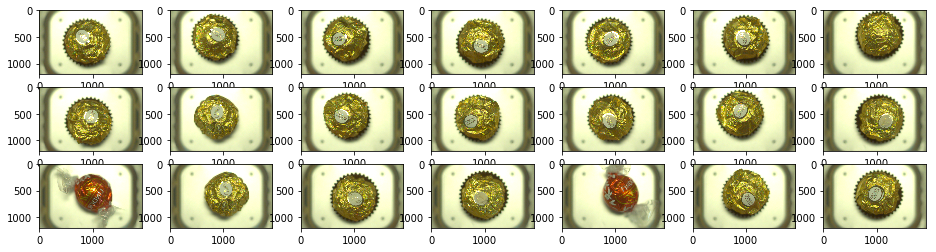

Validation labels:  [0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1]


In [4]:
plt.figure(figsize=(16, 4))

for idx in range(1, 22):    
    plt.subplot(3, 7, idx)
    plt.imshow(d_valid[idx - 1])
plt.show()

print('Validation labels: ', l_valid)

## Step 3: Define image classification model in Tensorflow

In [5]:
class ChocolateClassifier:
    def __init__(self, im_width: 'int | width of input in pixels', 
                       im_height: 'int | height of input in pixels', 
                       num_classes: 'int | number of classes'):
        self._im_width = im_width
        self._im_height = im_height
        self._num_classes = num_classes
        
        self.X = tf.placeholder(tf.float32, shape=[None, self._im_width, self._im_height, IM_CHANNELS], name='ChocolateClassifer/X')
        self.Y = tf.placeholder(tf.uint8, shape=[None,])
    
        self._preprocess_X()
        self._create_network()
        self._create_loss_and_optimizer()
        self._create_prediction()
    
    def _preprocess_X(self):
        self._X = self.X / 255.
        self._X = tf.image.resize(self._X, tf.constant([int(self._im_width * 0.2), int(self._im_height * 0.2)], dtype=tf.int32))
        self._X = tf.image.crop_to_bounding_box(self._X, 40, 90, 160, 160)

    def _create_network(self):
        self._C1 = tf.layers.conv2d(self._X, filters=16, kernel_size=(16, 16), strides=(8, 8), padding='SAME', activation=tf.nn.relu)
        self._MP1 = tf.layers.max_pooling2d(self._C1, pool_size=(4,4), strides=(1,1))
        self._C2 = tf.layers.conv2d(self._C1, filters=16, kernel_size=(4, 4), strides=(2, 2), padding='VALID', activation=tf.nn.relu)
        self._MP2 = tf.layers.max_pooling2d(self._C2, pool_size=(2, 2), strides=(1, 1))
        self._MP2 = tf.nn.dropout(self._MP2, rate=0.20)
        self._F = tf.contrib.layers.flatten(self._MP1)
        self._FC = tf.layers.dense(self._F, units=128, activation=tf.nn.relu)
        self._FC = tf.nn.dropout(self._FC, rate=0.20)
        self._P = tf.layers.dense(self._FC, units=2)

    def _create_loss_and_optimizer(self):
        self._Y = tf.one_hot(self.Y, depth=self._num_classes)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self._Y, logits=self._P))
        self.train = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(self.loss)
        
    def _create_prediction(self):
        self.predict = tf.argmax(self._P, axis=-1)

## Step 4: Sanity check image pre-processing

W0326 12:13:04.544167 140295665641280 deprecation.py:323] From <ipython-input-5-e8800722ed83>:23: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0326 12:13:04.545822 140295665641280 deprecation.py:323] From /home/taher/Documents/Research/Active_ALE/lib/python3.6/site-packages/tensorflow_core/python/layers/convolutional.py:424: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0326 12:13:04.556437 140295665641280 deprecation.py:323] From <ipython-input-5-e8800722ed83>:24: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0326 12:13:04.574765 140295665641280 lazy_loader.py:50] 
The TensorFlow contrib mod

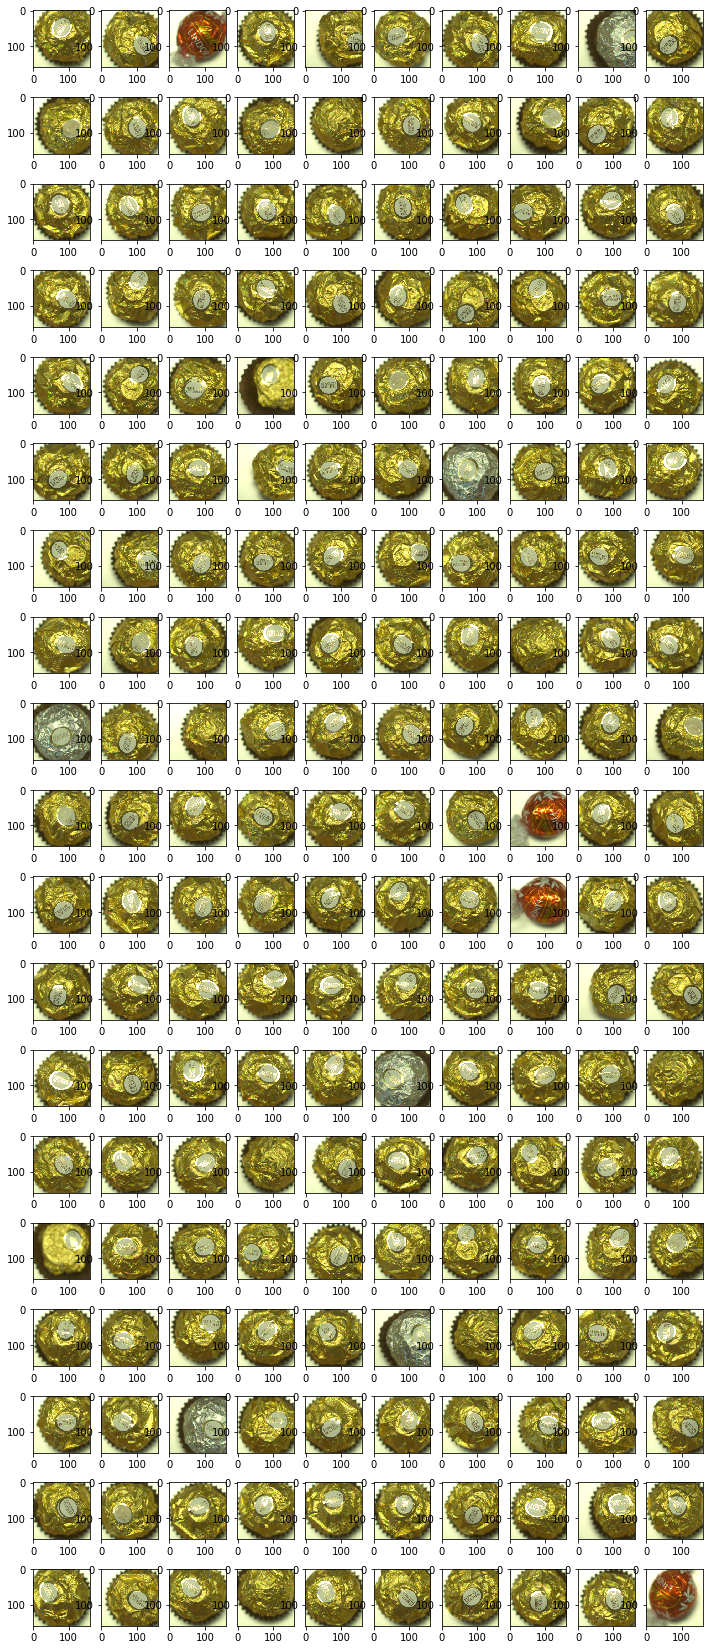

In [6]:
tf.reset_default_graph()

CC = ChocolateClassifier(IM_HEIGHT, IM_WIDTH, NUM_CLASSES)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.figure(figsize=(12, 30))
    for idx in range(1, len(d_train) + 1):
        im = sess.run(CC._X, feed_dict={CC.X: d_train[idx - 1: idx]})
        plt.subplot(19, 10, idx)
        plt.imshow(im[0, :, :, :])
        
    plt.show()

## Step 5: Train

In [7]:
tf.reset_default_graph()

CC = ChocolateClassifier(IM_HEIGHT, IM_WIDTH, NUM_CLASSES)

losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(EPOCHS):
        for _ in range(len(d_train) // BATCH_SIZE):
            mini_batch = np.random.randint(0, len(d_train), size=(BATCH_SIZE, ))            
            [loss, _] = sess.run([CC.loss, CC.train], feed_dict={CC.X: np.take(d_train, mini_batch, axis=0), \
                                                                 CC.Y: np.take(l_train, mini_batch, axis=0)})
            losses.append(loss)

            
    predictions = sess.run(CC.predict, feed_dict={CC.X: d_valid})

    print('Predictions      : ', predictions)
    print('Validation Labels: ', l_valid)


Predictions      :  [0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Validation Labels:  [0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1]


## Step 6: Analyse Model

In [8]:
# Generate confusion matrix

accuracy = np.sum(predictions == l_valid) / len(predictions)
print('Overall model accuracy on validation set: ', accuracy * 100, '%')

tn, fp, fn, tp = sklearn.metrics.confusion_matrix(l_valid, predictions).ravel()
print('Confusion matrix')
print('                        __________Ground-Truth________')
print('                        Undamaged______________Damaged')
print('Pr-   |   Undamaged |     ', tn, '                  ', fn)
print('ed-   |             |')
print('ic-   |    Damaged  |     ', fp, '                   ', tp)
print('ted   |             |')
print('')
precision = tn / (tn + fn)
recall = tn / (tn + fp)
print('Model Precision: {:.2f}'.format(precision))
print('Model Recall: {:.2f}'.format(recall))
print('F-score: {:.2f}'.format((2 * recall * precision) / (recall + precision)))

Overall model accuracy on validation set:  90.9090909090909 %
Confusion matrix
                        __________Ground-Truth________
                        Undamaged______________Damaged
Pr-   |   Undamaged |      10                    2
ed-   |             |
ic-   |    Damaged  |      0                     10
ted   |             |

Model Precision: 0.83
Model Recall: 1.00
F-score: 0.91


### Take-aways:
- High recall score of 100% indicates the model is good at not incorrectly rejecting undamaged packaging.
- High Precision of 83% score of indicates model is relatively good at not incorrectly accepting damaged packaging as undamaged packaging.
- Finally, F-score of 91% indicates model is overall relatively good.
- Overall, the model makes mistakes on the damaged packaging and this may be fixed by adding more training data (ideally) or performing some more data augmentation.